Doing what Shawn did

In [1]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


from library.datasets import Signal_Images_Dataset
from library.nn_training import select_device, train_and_eval, Custom_Model
from library.plotting import plot_loss_curves, setup_high_quality_mpl_params, plot_prediction_linearity

# setup_high_quality_mpl_params()


In [2]:
device = select_device()

Device:  cuda


In [14]:
class Res_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm3d(num_features=out_channels),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) + x
        x = self.last_activation(x)
        return x


class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block_a = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm3d(num_features=out_channels),
        )
        self.block_b = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding="same"),
            nn.BatchNorm3d(num_features=out_channels),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        out_block_a = self.block_a(x)
        out_block_b = self.block_b(x)
        x = out_block_a + out_block_b
        x = self.last_activation(x)
        return x


class CNN_Res(Custom_Model):
    def __init__(self, nickname, model_dir,):
        super().__init__(nickname, model_dir)

        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding="same", bias=False),
            nn.BatchNorm3d(num_features=64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1),
            *[Res_Block(in_channels=64, out_channels=64) for _ in range(3)],
            Conv_Block(in_channels=64, out_channels=128),
            *[Res_Block(in_channels=128, out_channels=128) for _ in range(3)],
            Conv_Block(in_channels=128, out_channels=256),
            *[Res_Block(in_channels=256, out_channels=256) for _ in range(5)],
            Conv_Block(in_channels=256, out_channels=512),
            *[Res_Block(in_channels=512, out_channels=512) for _ in range(2)],
        )

        self.dense = nn.Sequential(
            nn.Linear(in_features=512, out_features=1000),
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=1),
        )
        
        self.double()

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=(1,2,3))
        # x = torch.squeeze(x)
        x = self.dense(x) # squeeze?
        return x

In [11]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"

common_generate_kwargs = {
    "raw_signal_dir": "../../state/new_physics/data/raw/signal",
    "std_scale": True,
    "q_squared_veto": True,
    "balanced_classes": True,
    "num_events_per_set": 24_000,
    "num_sets_per_label": 30,
    "n_bins": 30,
}

datasets = {
    "train": Signal_Images_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Signal_Images_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,5), 
        **common_generate_kwargs
    )
    datasets["eval"].generate(
        raw_trials=range(5,10), 
        **common_generate_kwargs
    )

datasets["train"].load(device)
datasets["eval"].load(device)

opened raw file: [1/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_1_re.pkl
opened raw file: [2/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_2_re.pkl
opened raw file: [3/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_3_re.pkl
opened raw file: [4/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_4_re.pkl
opened raw file: [5/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.08_1_re.pkl
opened raw file: [6/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.08_2_re.pkl
opened raw file: [7/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.08_3_re.pkl
opened raw file: [8/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.08_4_re.pkl
opened raw file: [9/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.15_1_re.pkl
opened raw file: [10/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.15_2_re.pkl
opened raw file: [11/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.15_3_re.pkl
opened raw file: [12/175] ..\..\state\new_physics\data\raw\signal\dc9_-0.1

Image Visualization

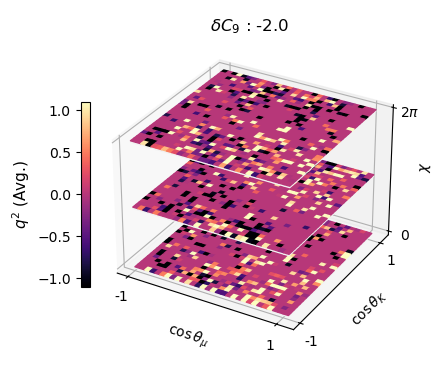

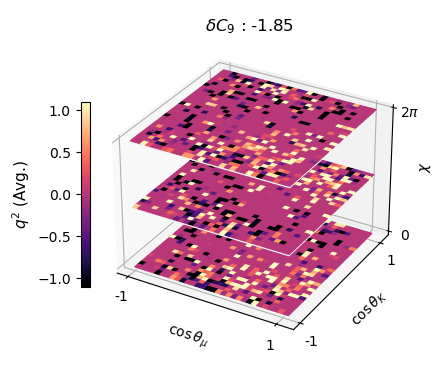

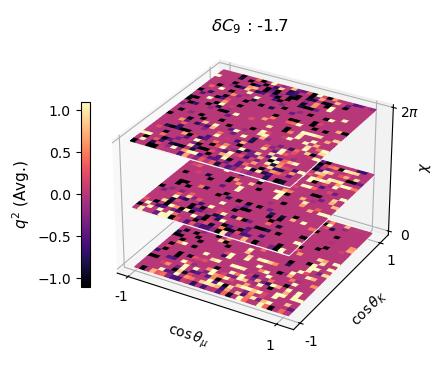

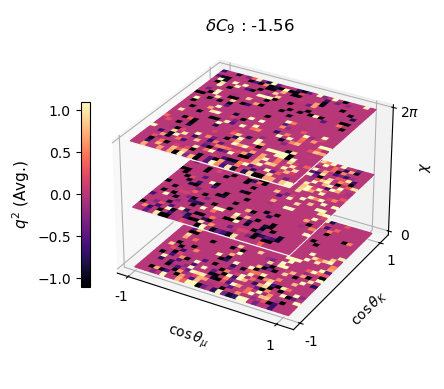

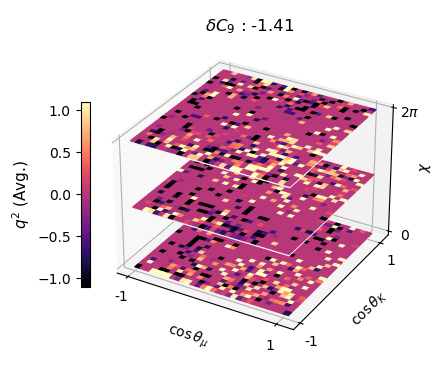

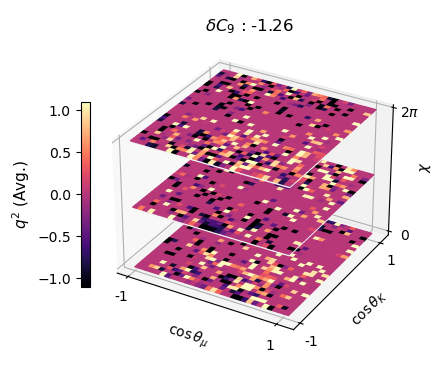

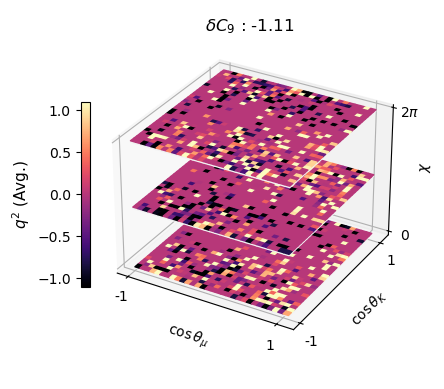

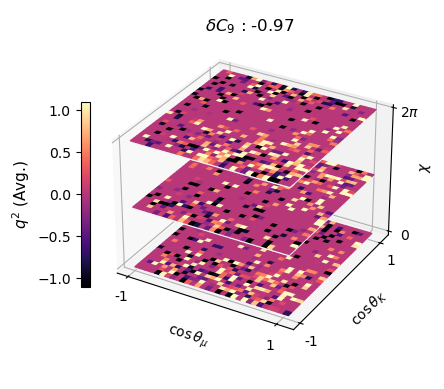

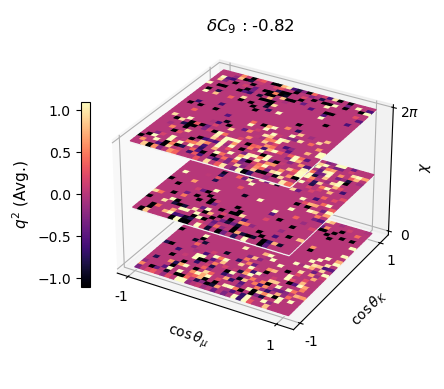

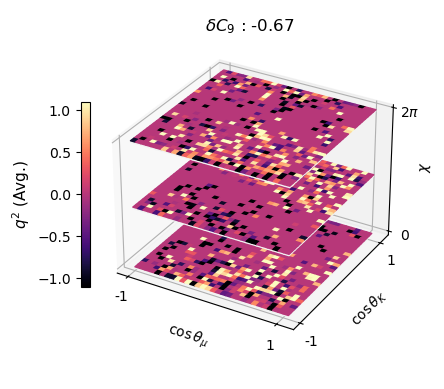

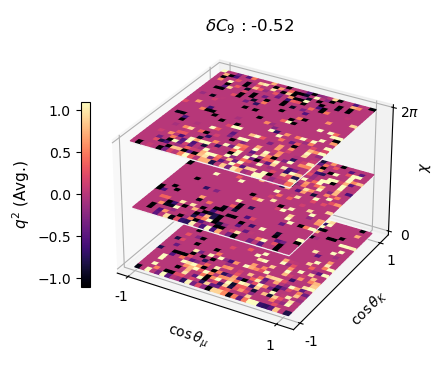

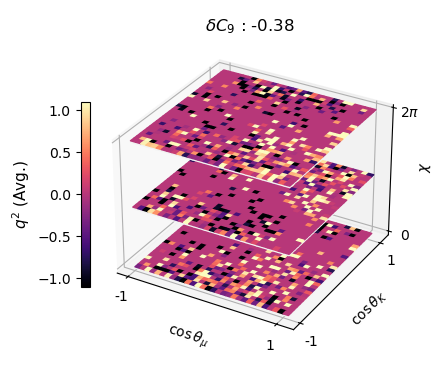

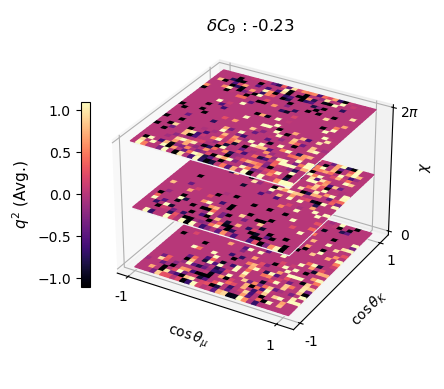

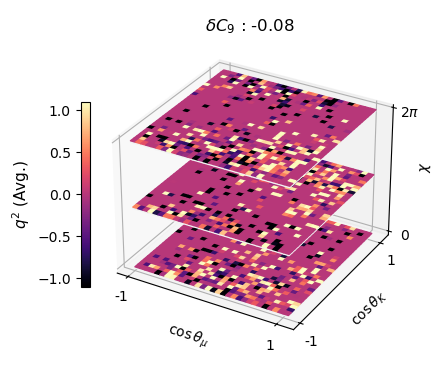

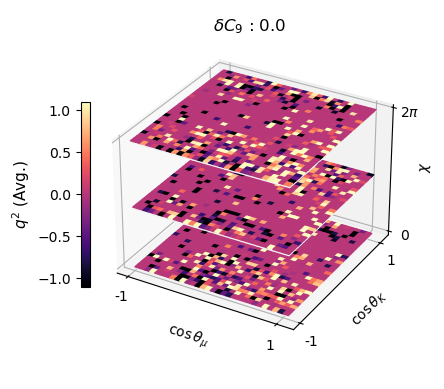

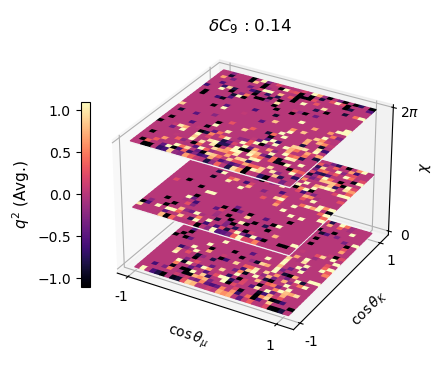

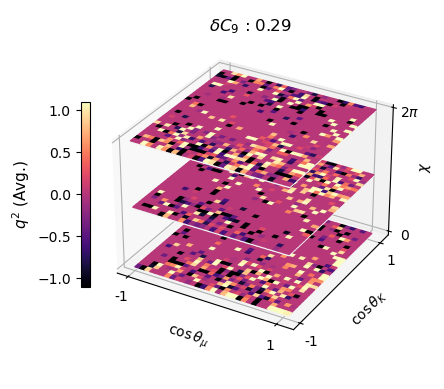

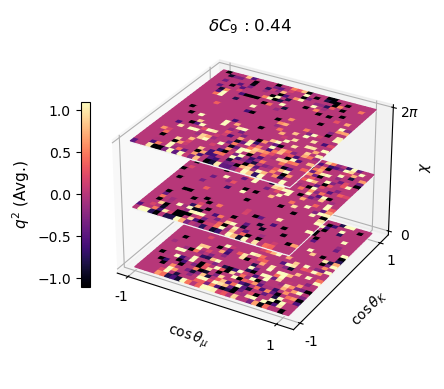

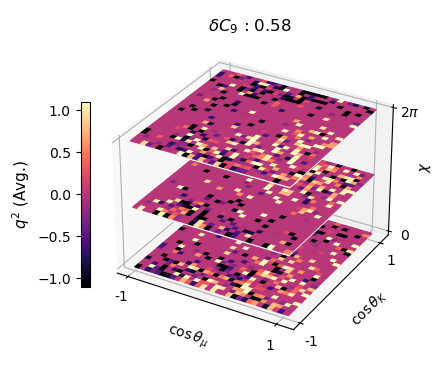

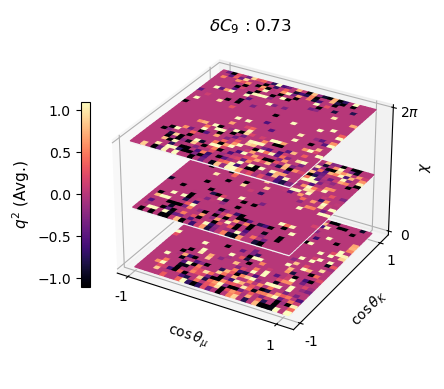

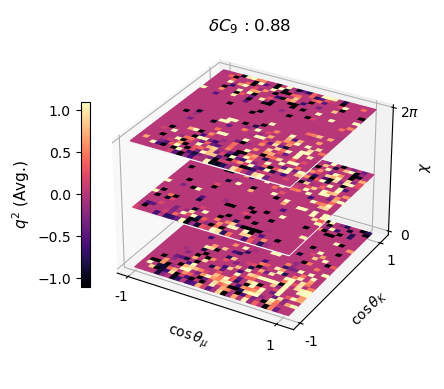

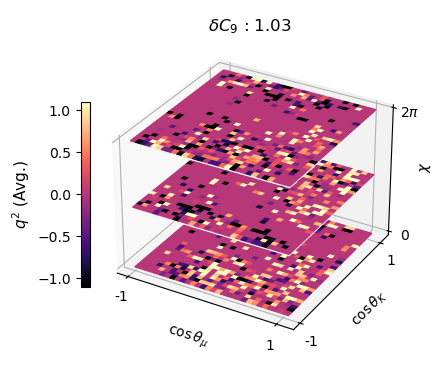

In [12]:
def plot_volume_slices(arr, n_slices=3, cmap=plt.cm.magma, note=""):
    """
    Plot slices of volumetric data.
    Slices are along the z-axis (axis 2).
    Array arr should be a three-dimensional array.
    Slices might not be evenly spaced along z-axis.
    """

    fig = plt.figure()
    ax_3d = fig.add_subplot(projection="3d")

    var_dim = {
        0: "chi",
        1: "costheta_mu",
        2: "costheta_K",
    }

    dim_ind_cart = { # dont change for now
        "x": 1,     
        "y": 2,
        "z": 0,  
    }

    norm=Normalize(vmin=-1.1, vmax=1.1)
    arr = arr.squeeze()
    arr = arr.cpu()
    arr = np.transpose(
        arr, 
        (dim_ind_cart["x"], dim_ind_cart["y"], dim_ind_cart["z"])
    )
    colors = cmap(norm(arr))
    
    cart_dim_shape = {
        dim_name: arr.shape[dim_ind_cart[dim_name]] for dim_name in dim_ind_cart.keys()
    }

    def xy_plane(z_pos):
        x, y = np.indices(
            (cart_dim_shape["x"] + 1, cart_dim_shape["y"] + 1)
        )
        z = np.full(
            (cart_dim_shape["x"] + 1, cart_dim_shape["y"] + 1), z_pos
        )
        return x, y, z
    
    def plot_slice(z_index):
        x, y, z = xy_plane(z_index) 
        ax_3d.plot_surface(
            x, y, z, 
            rstride=1, cstride=1, 
            facecolors=colors[:,:,z_index], 
            shade=False,
        )

    def plot_outline(z_index, offset=0.3):
        x, y, z = xy_plane(z_index - offset)
        
        ax_3d.plot_surface(
            x, y, z, 
            rstride=1, cstride=1, 
            shade=False,
            color="#f2f2f2",
            edgecolor="#f2f2f2", 
        )

    z_indices = np.linspace(0, cart_dim_shape["z"]-1, n_slices, dtype=int) # forces integer indices
    for i in z_indices:
        plot_outline(i)
        plot_slice(i)

    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax_3d, location="left", shrink=0.5, pad=-0.05)
    cbar.set_label(r"${q^2}$ (Avg.)", size=11)

    ax_labels = {
        "chi": r"$\chi$", 
        "costheta_mu": r"$\cos\theta_\mu$",
        "costheta_K": r"$\cos\theta_K$",
    }

    ax_3d.set_xlabel(ax_labels[var_dim[dim_ind_cart["x"]]], labelpad=0)
    ax_3d.set_ylabel(ax_labels[var_dim[dim_ind_cart["y"]]], labelpad=0)
    # ax_3d.zaxis.set_rotate_label(False)
    ax_3d.set_zlabel(ax_labels[var_dim[dim_ind_cart["z"]]], labelpad=-3,)#rotation="horizontal") 

    ticks = {
        "costheta_mu": ["-1", "1"],
        "costheta_K": ["-1", "1"],
        "chi": ['0', r"$2\pi$"],
    }      

    ax_3d.set_xticks([0, arr.shape[dim_ind_cart["x"]]-1], ticks[var_dim[dim_ind_cart["x"]]])
    ax_3d.set_yticks([0, arr.shape[dim_ind_cart["y"]]-1], ticks[var_dim[dim_ind_cart["y"]]])
    ax_3d.set_zticks([0, arr.shape[dim_ind_cart["z"]]-1], ticks[var_dim[dim_ind_cart["z"]]])

    ax_3d.tick_params(pad=0.3)

    ax_3d.set_box_aspect(None, zoom=0.85)

    ax_3d.set_title(f"{note}", loc="center", y=1)

for i, (arr, label) in enumerate(zip(datasets["train"].features, datasets["train"].labels)):
    n_slices = 3
    if i%60==0:
        plot_volume_slices(arr, n_slices=n_slices, note=r"$\delta C_9$ : "+f"{label}")
        # plt.savefig(f"{i}", bbox_inches="tight")
        plt.show()
        plt.close()

In [ ]:
retrain = True

model = CNN_Res("cnn_res_with_checkpoints", "../../state/new_physics/models")

if retrain:
    learning_rate = 1e-3
    epochs = 20
    train_batch_size = 128
    eval_batch_size = 128
    loss_fn = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=None,
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(
        model.loss_table["epoch"][plot_epoch_start:], 
        model.loss_table["train_loss"][plot_epoch_start:], 
        model.loss_table["eval_loss"][plot_epoch_start:], 
        ax
    )
    # ax.set_yscale("log")
    plt.show()
else:
    model.load_final()
    # model.load_checkpoint(epoch_number=10)
    model.to(device)

Evaluate model

In [37]:
yhat = model(datasets["eval"].features)
avgs = yhat.reshape(-1, 30).mean(1).detach().cpu().numpy()
stds = yhat.reshape(-1, 30).std(1).detach().cpu().numpy()

In [ ]:
y = datasets["eval"].labels
unique_y = y.reshape(-1, 30).mean(1).detach().cpu().numpy()
unique_y

In [ ]:
fig, ax = plt.subplots()
plot_prediction_linearity(ax, unique_y, avgs, stds)
